In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse

In [5]:
# Step 1: Load the dataset
df = pd.read_csv("filtered_books_dataset.csv")
df

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,745,47,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,299,745,47,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,745,47,5/1/2004,Scholastic Inc.
4,12,The Ultimate Hitchhiker's Guide: Five Complete...,Douglas Adams,4.38,0517226952,9780517226957,eng,299,3628,254,11/1/2005,Gramercy Books
...,...,...,...,...,...,...,...,...,...,...,...,...
4905,45616,A Última Batalha (As Crónicas de Nárnia #7),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.03,9722332201,9780582461536,por,149,211,24,7/17/2004,Editorial Presença
4906,45623,O Sobrinho do Mágico (As Crónicas de Nárnia #1),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.04,9722329987,9780582461536,por,147,396,37,4/8/2003,Editorial Presença
4907,45625,A Viagem do Caminheiro da Alvorada (As Crónica...,C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.09,9722331329,9780582461536,por,176,161,14,9/1/2004,Editorial Presença
4908,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press


In [7]:
df.columns = df.columns.str.strip()

In [9]:
# Step 2: Combine title and authors into one string
df['combined_features'] = df['title'].astype(str) + " " + df['authors'].astype(str)

In [11]:
# Step 3: Vectorize combined text using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

In [13]:
numerical_cols = ['average_rating', 'ratings_count', 'text_reviews_count', 'num_pages']

In [15]:
# Step 4: Scale numerical features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(df[numerical_cols])

In [17]:
# Step 5: Combine text + numerical features
full_features = scipy.sparse.hstack([tfidf_matrix, scaled_numerical])

In [19]:
# Step 6: Apply KMeans clustering
kmeans = KMeans(n_clusters=20, random_state=42)
df['cluster'] = kmeans.fit_predict(full_features)

In [21]:
# Step 7: Recommendation function to handle partial matching
def recommend_books(book_query, df, tfidf_matrix, top_n=5):
    # Make the book_query lowercase for case-insensitive search
    book_query = book_query.lower()

    # Search for books that match the query (either title or author)
    matched_indices = df[df['combined_features'].str.lower().str.contains(book_query)].index

    if len(matched_indices) == 0:
        return "❌ No books found matching your search."

    # Take the first matched book (if multiple matches are found, you can adjust this logic)
    idx = matched_indices[0]

    # Compute similarity of the selected book with all others
    cosine_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()

    # Get the indices of the most similar books
    similar_indices = cosine_sim.argsort()[-top_n-1:-1][::-1]  # Exclude the book itself

    # Return the top recommended books
    return df.iloc[similar_indices][['title', 'authors', 'average_rating']]

In [23]:
# 🔍 Example usage: Get book recommendations for a given book title
preference = "Harry potter"

# Call the recommend_books function
recommendations = recommend_books(preference, df, tfidf_matrix)

# Print the recommended books
print(f"Recommendations for '{preference}':\n")
recommendations

Recommendations for 'Harry potter':



,title,authors,average_rating
262,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57
2032,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling/Mary GrandPré,4.42
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49
3989,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling/Mary GrandPré,4.47
3,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56


# ROC curve

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [36]:
df= pd.read_csv("filtered_books_dataset.csv")
df

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,745,47,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,299,745,47,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,745,47,5/1/2004,Scholastic Inc.
4,12,The Ultimate Hitchhiker's Guide: Five Complete...,Douglas Adams,4.38,0517226952,9780517226957,eng,299,3628,254,11/1/2005,Gramercy Books
...,...,...,...,...,...,...,...,...,...,...,...,...
4905,45616,A Última Batalha (As Crónicas de Nárnia #7),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.03,9722332201,9780582461536,por,149,211,24,7/17/2004,Editorial Presença
4906,45623,O Sobrinho do Mágico (As Crónicas de Nárnia #1),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.04,9722329987,9780582461536,por,147,396,37,4/8/2003,Editorial Presença
4907,45625,A Viagem do Caminheiro da Alvorada (As Crónica...,C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.09,9722331329,9780582461536,por,176,161,14,9/1/2004,Editorial Presença
4908,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press


In [38]:
# Strip any extra spaces from column names
df.columns = df.columns.str.strip()

# Check the column names to ensure the 'num_pages' column exists
print(df.columns)

# If 'num_pages' doesn't exist, remove it from the list or handle it appropriately
numerical_cols = ['average_rating', 'ratings_count', 'text_reviews_count', 'num_pages']
numerical_cols = [col for col in numerical_cols if col in df.columns]  # Remove missing columns

# Fill missing values for the existing columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())


Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')


In [40]:
X = df[numerical_cols]  # Use your numerical features or some model's predictions
y = (df['average_rating'] > 4).astype(int)  # Example: '1' if rating > 4, else '0'

In [42]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
# Fit a classifier (using Logistic Regression for demonstration)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [46]:
# Get predicted probabilities (for ROC curve, we need probabilities, not just labels)
y_prob = classifier.predict_proba(X_test)[:, 1]

In [48]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

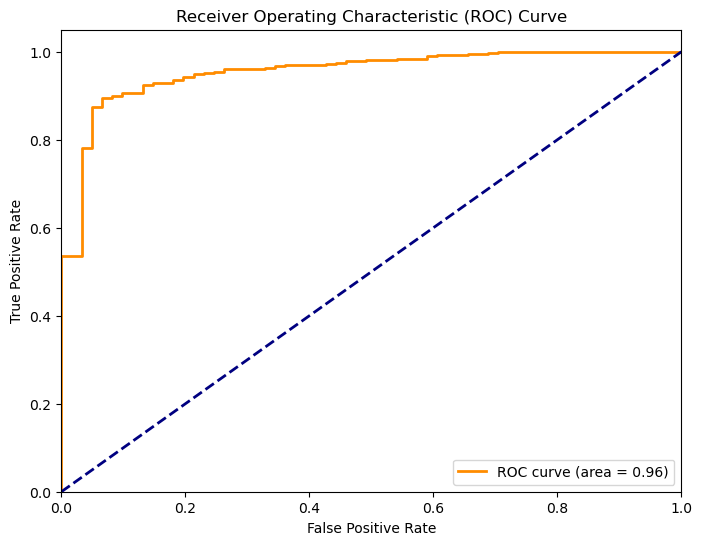

In [50]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix

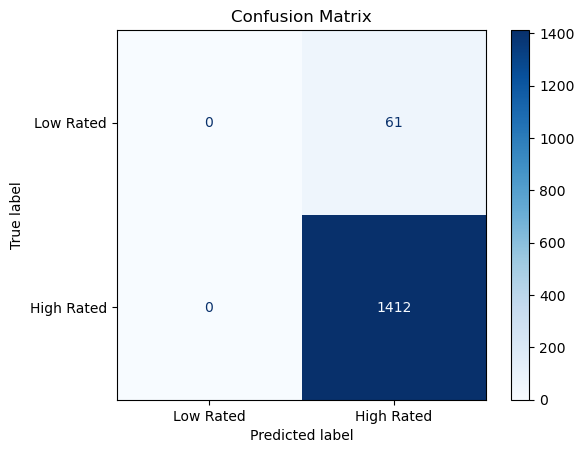

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Train the model (use any classifier here)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Rated", "High Rated"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


# F1 score, Sensitivity And Specificity 

In [56]:
from sklearn.metrics import f1_score, recall_score, confusion_matrix

# Predictions
y_pred = classifier.predict(X_test)

# F1 Score (%)
f1 = f1_score(y_test, y_pred) * 100
print(f"F1 Score: {f1:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Sensitivity (Recall for High Rated) in %
sensitivity = (tp / (tp + fn)) * 100
print(f"Sensitivity (Recall for High Rated): {sensitivity:.2f}%")

# Specificity (Recall for Low Rated) in %
specificity = (tn / (tn + fp)) * 100
print(f"Specificity (Recall for Low Rated): {specificity:.2f}%")

F1 Score: 97.89%
Sensitivity (Recall for High Rated): 100.00%
Specificity (Recall for Low Rated): 0.00%
